In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import tri
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [7]:
# Step 1: Define problem parameters
L = 50  # Length of domain in x and y directions
T0 = 100
Nx, Ny = L, L  # Number of grid points in x and y
alpha = 3  # Thermal diffusivity
h = 0.5206164
print(h ** 2 / (2*alpha))
dt = 0.0125  # Time step size
nt = 2000  # Number of time steps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64
print(device)

0.045173572658159994
cpu


In [8]:
def apply_boundary_condition(A, b):
    pass

def create_preconditioner(A):
    sparse_indices = A._indices()
    sparse_values = A._values()
    
    PC = torch.zeros(A.shape[0], device=device, dtype=dtype)
    for i in range(sparse_indices.shape[1]):
        row, col = sparse_indices[:, i]
        if row == col:  # Check if it's a diagonal element
            PC[row] = sparse_values[i] 
    
    return PC


def apply_preconditioner(PC, r, tol=1e-6, max_iter=10):
    z = (1 / PC) * r
    # z = torch.linalg.solve(PC, r)
    return z

def conjugate_gradient(A, b, M, a_tol=1e-6, r_tol=1e-6, max_iter=100):
    
    x = torch.zeros_like(b, device=device, dtype=dtype)  # Initial guess (zero vector)
    r = b - A @ x            # Initial residual
    z = apply_preconditioner(M, r)  # Preconditioned residual
    p = z                    # Initial search direction

    r_norm = torch.linalg.vector_norm(r)
    
    for i in range(max_iter):
        Ap = A @ p           # Matrix-vector product A*p
        rz_scala = torch.dot(r, z)
        alpha =  rz_scala / torch.dot(p, Ap)  # Step size
        
        # Update the solution
        x = x + alpha * p
        
        # Update residual
        r_new = r - alpha * Ap
        
        r_new_norm = torch.linalg.vector_norm(r_new)
        # print(r_new_norm / r_norm)
        
        if r_new_norm < a_tol or (r_new_norm / r_norm) < r_tol:
            print(f"Converged in {i} iterations", r_new_norm < a_tol, (r_new_norm / r_norm) < r_tol)
            break
        
        # Apply the preconditioner iteratively
        z_new = apply_preconditioner(M, r_new)
        
        # Compute beta for the next search direction
        beta = torch.dot(r_new, z_new) / rz_scala
        
        # Update the search direction
        p = z_new + beta * p
        
        # Update residuals and preconditioned residuals for next iteration
        r = r_new
        z = z_new
        
    else:
        print(f"Did not converge in {i} iterations", r_new_norm < a_tol, (r_new_norm / r_norm) < r_tol)
    return x

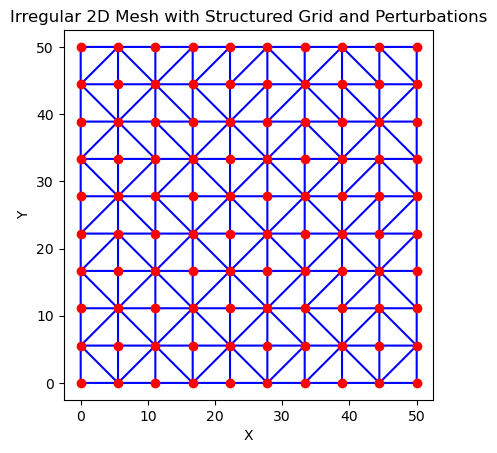

In [18]:
# Step 2: Generate grid (structured triangular mesh)
x = np.linspace(0, L, 10)  # 10 points along x-axis
y = np.linspace(0, L, 10)  # 10 points along y-axis
X, Y = np.meshgrid(x, y)
# Step 2: Add irregular perturbations to the grid points
# Flatten the grid and add some noise for irregularity
# X = X.flatten() 
# Y = Y.flatten() 
X = X.flatten() + 2 * (np.random.rand(X.size) - 1)
Y = Y.flatten() + 2 * (np.random.rand(Y.size) - 1)

# Step 3: Triangulate the irregular grid using matplotlib.tri.Triangulation
triangulation = tri.Triangulation(X, Y)
triangulation = tri.Triangulation(X.flatten(), Y.flatten())

plt.triplot(triangulation, color='blue')
plt.plot(X, Y, 'o', color='red')

plt.gca().set_aspect('equal')
plt.title('Irregular 2D Mesh with Structured Grid and Perturbations')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [5]:
# Step 3: Initial condition
u0 = torch.zeros((L * L,)).to(device=device, dtype=dtype)
u0[30 * L: 30 * L + L] = T0

In [14]:
def shape_function_gradients():
    return torch.tensor([[-1, -1], [1, 0], [0, 1]], dtype=dtype)

def jacobian(coords):
    dN_dxi = shape_function_gradients()
    J = coords.T @ dN_dxi 
    
    return J

def assemble_matrices(triangulation, alpha):
    npoints = len(triangulation.x)  # Total number of points in the mesh
    
    # Lists to store the indices and values of non-zero elements for K and M
    rows, cols, K_vals, M_vals = [], [], [], []
    
    for element in triangulation.triangles:
        # Get the coordinates of the three vertices of the triangle
        vertices = element[:]
        coords = torch.tensor([[x, y] for x, y in zip(triangulation.x[vertices], triangulation.y[vertices])], dtype=dtype)
        
        ###############################################################################################################
        # Calculate area of the triangle using the determinant method
        area = 0.5 * torch.linalg.det(torch.tensor([
            [1, coords[0, 0], coords[0, 1]],
            [1, coords[1, 0], coords[1, 1]],
            [1, coords[2, 0], coords[2, 1]]
        ]))

        # Mass matrix for a triangular element
        Me = (area / 12) * torch.tensor([[2, 0, 0],
                                         [0, 2, 0],
                                         [0, 0, 2]])

        J = jacobian(coords)
        det_J = torch.linalg.det(J)   # = 2 * area
        inv_J = torch.linalg.inv(J)
        
        dN_dxi = shape_function_gradients()
        dN_dxy = inv_J @ dN_dxi.T  # dN/dx, dN/dy 2x2  3x2 --> (2x3)

        # Stiffness matrix
        Ke = np.zeros((3, 3))
        for i in range(3):
            for j in range(3):
                Ke[i, j] = alpha * det_J * area * (dN_dxy[0, i] * dN_dxy[0, j] + dN_dxy[1, i] * dN_dxy[1, j]) 
        ################################################################################################################
        # Add local contributions to the global matrices
        for i in range(3):
            for j in range(3):
                # Store K and M values in sparse form (row, col, value)
                rows.append(vertices[i])
                cols.append(vertices[j])
                K_vals.append(Ke[i, j])
                M_vals.append(Me[i, j])
    
    # Create sparse tensors from the accumulated lists
    K = torch.sparse_coo_tensor(
        indices=[rows, cols],
        values=K_vals,
        size=(npoints, npoints)
    )
    
    M = torch.sparse_coo_tensor(
        indices=[rows, cols],
        values=M_vals,
        size=(npoints, npoints)
    )
    
    return K, M

K, M = assemble_matrices(triangulation, alpha)
K = K.to(device=device, dtype=dtype)
M = M.to(device=device, dtype=dtype)

tensor(1.0412, dtype=torch.float64) tensor(0.5206, dtype=torch.float64) tensor([[-0.9800, -0.9800],
        [ 0.9800,  0.0000]], dtype=torch.float64)
tensor(1.0412, dtype=torch.float64) tensor(0.5206, dtype=torch.float64) tensor([[ 0.0000, -0.9800],
        [ 0.9800,  0.9800]], dtype=torch.float64)
tensor(1.0412, dtype=torch.float64) tensor(0.5206, dtype=torch.float64) tensor([[-0.9800, -0.0000],
        [ 0.9800, -0.9800]], dtype=torch.float64)
tensor(1.0412, dtype=torch.float64) tensor(0.5206, dtype=torch.float64) tensor([[-0.0000, -0.9800],
        [ 0.9800,  0.0000]], dtype=torch.float64)
tensor(1.0412, dtype=torch.float64) tensor(0.5206, dtype=torch.float64) tensor([[ 0.0000,  0.9800],
        [-0.9800,  0.0000]], dtype=torch.float64)
tensor(1.0412, dtype=torch.float64) tensor(0.5206, dtype=torch.float64) tensor([[ 0.9800,  0.0000],
        [-0.9800,  0.9800]], dtype=torch.float64)
tensor(1.0412, dtype=torch.float64) tensor(0.5206, dtype=torch.float64) tensor([[-0.9800, -0.0000],


In [7]:
U = torch.zeros((nt, L, L)).to(device=device, dtype=dtype)
U[0,:,:] = u0.reshape((L, L))

u = u0
M_dt = M * (1 / dt)
A = M_dt + K

In [8]:
dirichlet_boundary_nodes = torch.arange(30 * L, 30 * L + L, device=device)
boundary_values = torch.ones_like(dirichlet_boundary_nodes, device=device, dtype=dtype) * T0

sparse_indices = A._indices() # apply boundary condition
sparse_values = A._values()

mask = ~torch.isin(sparse_indices[0], dirichlet_boundary_nodes) 
new_indices = sparse_indices[:, mask]
new_values = sparse_values[mask]

identity_indices = torch.stack([dirichlet_boundary_nodes, dirichlet_boundary_nodes], dim=0).to(device=device, dtype=dtype)  # Diagonal indices
identity_values = torch.ones_like(dirichlet_boundary_nodes)  # Diagonal values are set to 1.0

final_indices = torch.cat([new_indices, identity_indices], dim=1)
final_values = torch.cat([new_values, identity_values])
A = torch.sparse_coo_tensor(final_indices, final_values, A.shape)

PC = create_preconditioner(A)

In [9]:
for n in range(1, nt):
    print(f"{n}", end=" ")
    b = torch.sparse.mm(M_dt, u.unsqueeze(1)).squeeze(1)
    
    b[dirichlet_boundary_nodes] = boundary_values # apply boundary condition
    u = conjugate_gradient(A, b, PC, a_tol=1e-5, r_tol=1e-5, max_iter=100)
    
    U[n, :, :] = u.reshape((L, L))

1 Did not converge in 99 iterations tensor(False) tensor(False)
2 Converged in 18 iterations tensor(False) tensor(True)
3 Converged in 18 iterations tensor(False) tensor(True)
4 Converged in 19 iterations tensor(False) tensor(True)
5 Converged in 19 iterations tensor(False) tensor(True)
6 Converged in 19 iterations tensor(False) tensor(True)
7 Converged in 20 iterations tensor(False) tensor(True)
8 Converged in 20 iterations tensor(False) tensor(True)
9 Converged in 20 iterations tensor(False) tensor(True)
10 Converged in 20 iterations tensor(False) tensor(True)
11 Converged in 19 iterations tensor(False) tensor(True)
12 Converged in 17 iterations tensor(False) tensor(True)
13 Converged in 16 iterations tensor(False) tensor(True)
14 Converged in 16 iterations tensor(False) tensor(True)
15 Converged in 16 iterations tensor(False) tensor(True)
16 Converged in 16 iterations tensor(False) tensor(True)
17 Converged in 16 iterations tensor(False) tensor(True)
18 Converged in 16 iterations te

In [10]:
def plotheatmap(tr, u_k , k):
    plt.clf()

    plt.title(f"Temperature at t = {k*dt:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.tripcolor(tr, u_k.flatten(), cmap=plt.cm.jet, vmin=0, vmax=100, shading='gouraud')
    plt.colorbar()

In [11]:
U = U.cpu()
def animate(k):
    plotheatmap(triangulation, U[k], k)

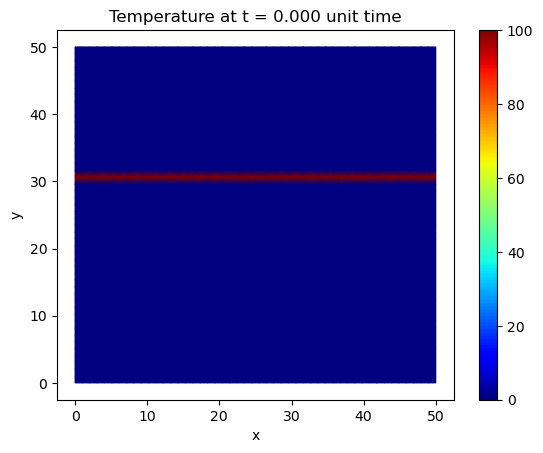

In [12]:
anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=nt, repeat=False)
anim.save("FEM - 2D Heat Equation - PCG - Sparse.gif")

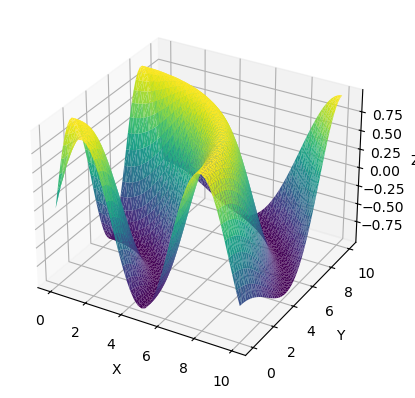

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Parameters
L = 10  # Length of the domain
Nx, Ny = 50, 50  # Number of points in x and y directions

# Create grid points
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)

# Define a Z function, e.g., a 3D surface like a sine wave
Z = np.sin(np.sqrt(X**2 + Y**2))

# Flatten the grid for triangulation
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()

# Create the 2D triangulation based on X and Y
triangulation = tri.Triangulation(X_flat, Y_flat)

# Now the triangulation is 2D, and Z values are used separately.
# You can still use it for 3D plotting or other purposes.

# Plotting with the Z values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface using the triangulation and Z values
ax.plot_trisurf(triangulation, Z_flat, cmap='viridis')

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
